In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"
os.environ["OMP_NUM_THREADS"] = "8"

import numpy as np
import pandas as pd
import h5py
import re
import sys
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap
matplotlib.rcParams['pdf.fonttype'] = 42
import operator
import copy
import pickle

import community
from random import sample
import networkx as nx
from backspinpy import CEF_obj

# Tomography
import tomography
from tomography.utils import pad_to_cube, pad_to_square, shift_simmetrize
from brainmap import *
from tomography.core import build_Design_Matrix
from tomography import get_x, get_plate, colorize, normalize_AUC

# Sklearn, scipy
import umap

from skimage.exposure import rescale_intensity
import scipy.ndimage as sc
import scipy.sparse
from scipy.integrate import simps
from sklearn.metrics.pairwise import euclidean_distances
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from skimage.segmentation import find_boundaries
from scipy import stats

from skimage.filters import gaussian
from skimage import exposure
from sklearn.svm import SVR
from sklearn.neighbors import NearestNeighbors
from skimage import morphology

from sklearn.cluster import DBSCAN, KMeans, SpectralClustering, AgglomerativeClustering, ward_tree
from scipy.cluster.hierarchy import ward, dendrogram, linkage, to_tree, dendrogram, fcluster
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from skimage.measure import find_contours
from skimage.morphology import convex_hull_image



from sklearn.decomposition import FactorAnalysis, NMF, non_negative_factorization, PCA

from helpers import *
sys.path.insert(0, os.path.abspath('../'))
from data_loaders import *

np.random.seed(11)

C:\Users\User\miniconda3\envs\tomographer-env\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\User\miniconda3\envs\tomographer-env\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finf

In [138]:
# Load the data in a dictionary of pd.DataFrames
df_list = []
sample_id_list = []
for i in ["A","B"]:
    layout = pd.read_table("Lizard{0}_layout.txt".format(i), index_col=0, dtype=str)
    sample_id_list.append(layout.values.flatten(order="F"))
    cef = CEF_obj()
    cef.readCEF("Lizard{0}_expression.cef".format(i))
    df_list.append(pd.DataFrame(data = cef.matrix, index=cef.row_attr_values[0], columns=cef.col_attr_values[0]) )
#cef.row_attr_values[0]
#cef.col_attr_values[0]

In [180]:
df_list = []
sample_id_list = []
layout = pd.read_table("Mouse9_layout.txt", index_col=0, dtype=str)
sample_id_list.append(layout.values.flatten(order="F"))
cef = CEF_obj()
cef.readCEF("GSE152989_Mouse9_expression.cef")
df_list.append(pd.DataFrame(data = cef.matrix, index=cef.row_attr_values[0], columns=cef.col_attr_values[0]) )
#cef.row_attr_values[0]
#cef.col_attr_values[0]
"""
for i in range(len(cef.matrix)):
               for j in range(len(cef.matrix[1])):
                              if cef.matrix[i][j] ==0:
                                  cef.matrix[i][j] = cef.matrix[i][j]+1000
                        
cef.matrix[1][1]
"""

'\nfor i in range(len(cef.matrix)):\n               for j in range(len(cef.matrix[1])):\n                              if cef.matrix[i][j] ==0:\n                                  cef.matrix[i][j] = cef.matrix[i][j]+1000\n                        \ncef.matrix[1][1]\n'

In [181]:
sample_id = np.hstack(sample_id_list)
df = pd.concat(df_list,axis=1)
df.columns = sample_id
df = df.loc[:,sorted( df.columns.values )]
df.index


Index(['ERCC-00009', 'ERCC-00012', 'ERCC-00013', 'ERCC-00014', 'ERCC-00016',
       'ERCC-00017', 'ERCC-00019', 'ERCC-00022', 'ERCC-00024', 'ERCC-00025',
       ...
       'Ppm1n', 'Rtn2', 'Fosb', 'Ercc1', 'Cd3eap', 'Ppp1r13l', 'Ercc2',
       'Mir343', 'Klc3', 'Ckm'],
      dtype='object', length=18688)

In [182]:
angles_name, angles_ix = np.unique( [i.split("_")[0] for i in df.columns], return_inverse=True )

In [183]:
data = {}
spikes = {}

In [184]:
angles_name
angles_ix
angle

'angle117'

In [185]:
for ix, angle in enumerate(angles_name):
    data[angle] = df.loc[:,angles_ix==ix].iloc[109:].astype(float)
    spikes[angle] = df.loc[:,angles_ix==ix].iloc[:109,:].astype(float)
    
del sample_id_list
del df_list

# add the expected x coordinate
for name_angle, df in data.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]
# do the same to the spikes
for name_angle, df in spikes.items():
    df.columns = df.columns + ["_x"+str(i) for i in range(df.shape[1])]

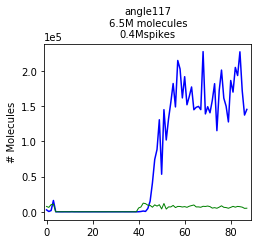

In [186]:
plt.figure(figsize=(16,3.5))
tomography.plot_raw_data_sum(data, spikes)

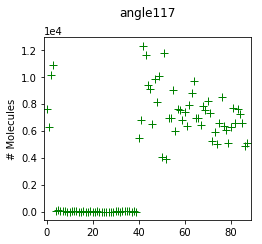

In [187]:
plt.figure(figsize=(16,3.5))
tomography.plot_raw_spikes(spikes)

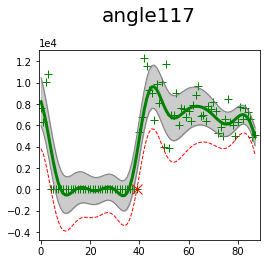

In [188]:
plt.figure(figsize=(23,3.5))
np.random.seed(15071990)
flag_low_spikes = {}
for i, (name_angle, spikes_df) in enumerate(spikes.items()):
    # Prepare model fit
    x = np.arange(0,spikes_df.shape[1], dtype=float)
    y = spikes_df.sum(0).values
    
    # Fit Etheroscedastic model
    y_new, y_std = tomography.predict_gp_heteroscedastic(y, x[:,None], x[:,None], verbose=False)
    
    # Flag samples that had too low spikes
    flag = y < y_new - 1.96*y_std
    flag_low_spikes[name_angle] = flag
    
    # Plot
    plt.subplot(151+i)
    plt.title("%s\n" % (name_angle), fontsize=20)
    tomography.plot_gp_with_std(x, y, y_new, y_std, flag)
    
    
# Remove low spikes
for name_angle in data.keys():
    data[name_angle] = data[name_angle].loc[:, ~(flag_low_spikes[name_angle])]
    spikes[name_angle] = spikes[name_angle].loc[:, ~(flag_low_spikes[name_angle])]

In [194]:
spikes[angle].loc[:, (df != 0).any(axis=0)]

,angle117_3_01_x0,angle117_3_02_x1,angle117_3_03_x2,angle117_3_04_x3,angle117_3_05_x4,angle117_3_06_x5,angle117_3_07_x6,angle117_3_08_x7,angle117_3_09_x8,angle117_3_12_x11,...,angle117_3_79_x78,angle117_3_80_x79,angle117_3_81_x80,angle117_3_82_x81,angle117_3_83_x82,angle117_3_84_x83,angle117_3_85_x84,angle117_3_86_x85,angle117_3_87_x86,angle117_3_88_x87
ERCC-00009,42.0,29.0,49.0,69.0,0.0,1.0,0.0,0.0,0.0,0.0,...,35.0,26.0,36.0,55.0,50.0,49.0,44.0,30.0,30.0,25.0
ERCC-00012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
ERCC-00014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
ERCC-00016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00019,2.0,1.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,1.0
ERCC-00022,20.0,21.0,23.0,21.0,0.0,1.0,0.0,0.0,0.0,0.0,...,15.0,13.0,15.0,24.0,17.0,34.0,14.0,20.0,16.0,10.0
ERCC-00024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ERCC-00025,1.0,6.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,0.0,1.0,1.0,0.0,1.0,2.0,0.0,0.0


In [193]:
# Calculate adjustment parameters
coordinates_dict, adjustments = tomography.use_gp_to_adjust_spikes_diff(spikes, q=0.3)

plt.figure(figsize=(17,5.5))
tomography.plot_spikes_adjustment(coordinates_dict)


# perform normalization
data_norm = {}
for name_angle in data.keys():
    data_norm[name_angle] = data[name_angle].copy()
    
for name_angle in data_norm.keys():
    data_norm[name_angle] *= adjustments[name_angle]

ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.

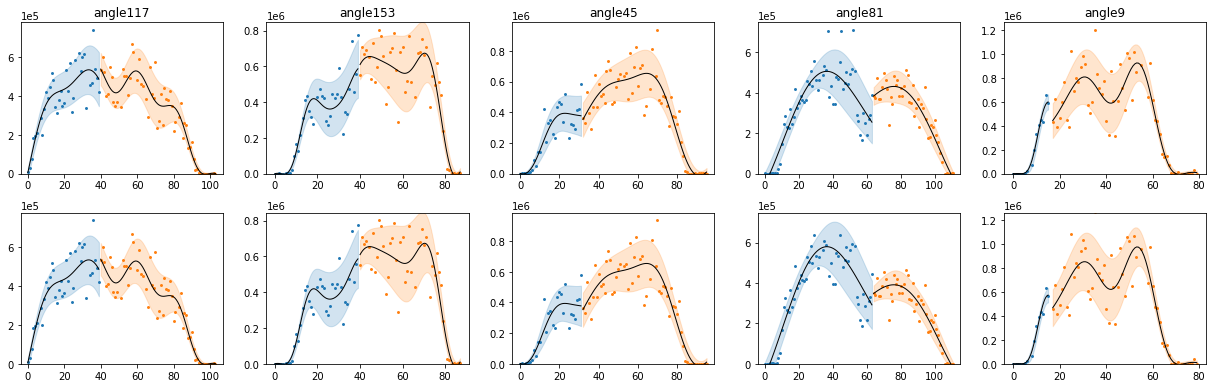

In [60]:
np.random.seed(15071990)
coordinates_dict, _ = tomography.use_gp_to_adjust_plates_diff(data_norm, q=0.3)

plt.figure(figsize=(17,5.5))
tomography.plot_plate_adjustment(coordinates_dict)

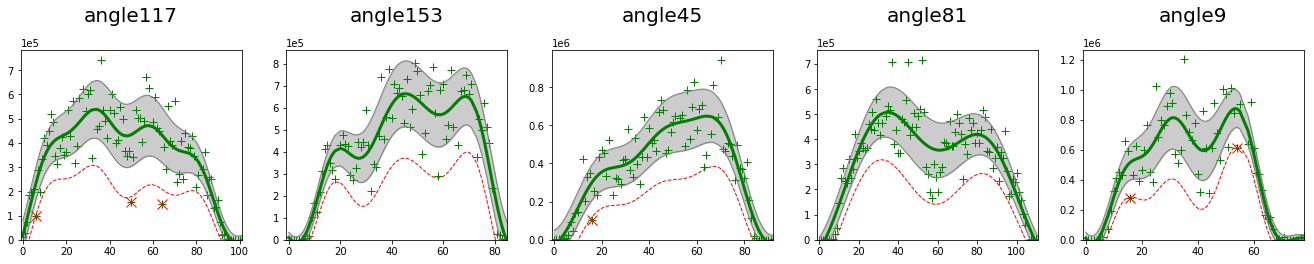

In [46]:
plt.figure(figsize=(23,3.5))
np.random.seed(15071990)
flag_low_sample = {}
for i, (name_angle, df) in enumerate(data_norm.items()):
    # Prepare model fit
    x = get_x(df)
    y = df.sum(0).values
    
    # Fit Etheroscedastic model
    y_new, y_std = tomography.predict_gp_heteroscedastic(y, x[:,None], x[:,None], verbose=False)
    
    # Flag samples that had too low spikes
    flag = y < y_new - 1.96*y_std
    flag_low_sample[name_angle] = flag
    
    # Plot
    plt.subplot(151+i)
    plt.title("%s\n" % (name_angle), fontsize=20)
    tomography.plot_gp_with_std(x, y, y_new, y_std, flag_low_sample[name_angle])
    plt.ylim(0,)
    
# remove flagged data points
for name_angle in data_norm.keys():
    data_norm[name_angle] = data_norm[name_angle].loc[:,~(flag_low_sample[name_angle]) ]

In [11]:
# AUC normalize
data_norm = normalize_AUC(data_norm)

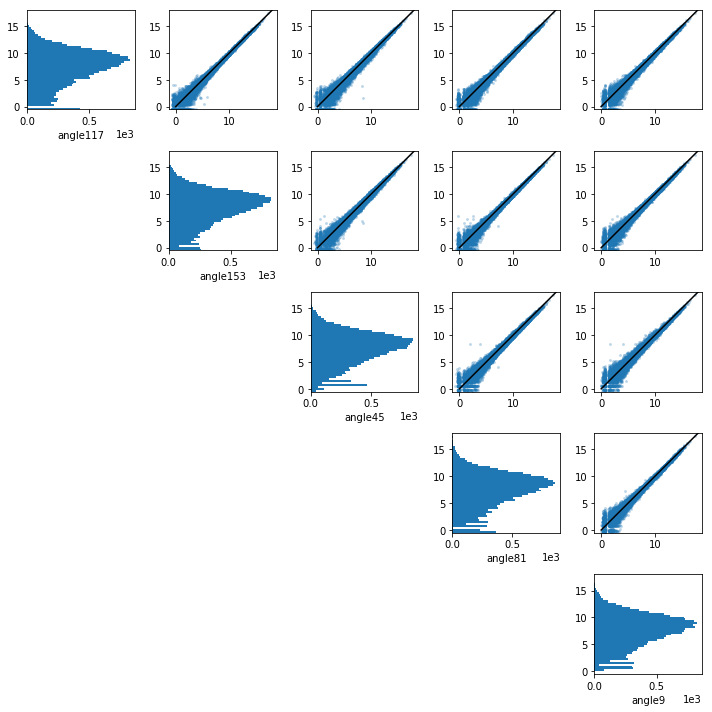

In [12]:
plt.figure(figsize=(10,10))
gs = plt.GridSpec(5,5)
for i, name_angle1 in enumerate(data_norm.keys()):
    for j, name_angle2 in enumerate(data_norm.keys()):
        if i < j:
            ax = plt.subplot(gs[i,j]) 
            ax.scatter(np.log2(data_norm[name_angle2].sum(1) + 1e-6),
                       np.log2(data_norm[name_angle1].sum(1) + 1e-6),
                       lw=0, s=8,alpha=0.3)
            ax.plot(np.arange(20),np.arange(20), c="k")
            plt.axis("equal")
            plt.xlim(-0.5, 18)
            plt.ylim(-0.5, 18)
        if i == j:
            ax = plt.subplot(gs[i,j]) 
            v = np.log2(data_norm[name_angle1].sum(1))
            ax.hist(v[np.isfinite(v)],bins=50,orientation="horizontal")
            plt.xlabel(name_angle1)
            plt.ylim(-0.5,18)
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.tight_layout()

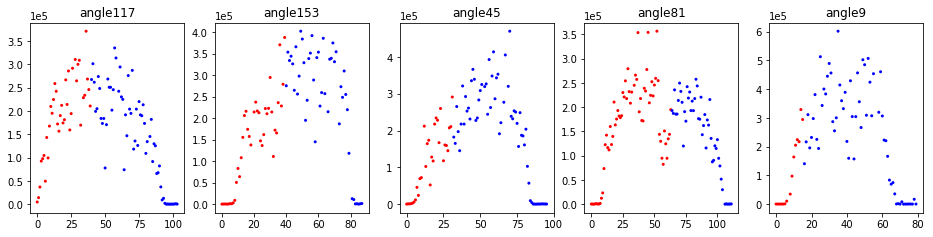

In [13]:
plt.figure(figsize=(16,3.5))
gs = plt.GridSpec(1,5)
for i, name_angle in enumerate(data_norm.keys()):
    ax = plt.subplot(gs[i])
    x = get_x(data_norm[name_angle])
    y = data_norm[name_angle].sum(0)
    c = np.array(["k","r", "b"])[get_plate(data_norm[name_angle])]
    ax.scatter(x,y, marker=".",lw=0, c=c)
    ax.set_title("%s" % name_angle)
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    
    
degrees_dict = {'angle117':117,'angle45':45,'angle9':9,'angle153':-27, 'angle81':81}
angles_dict = {}
for k, v in degrees_dict.items():
    angles_dict[k] = np.deg2rad(v+180.)
angles = np.array( [angles_dict[i] for i in data_norm.keys()] )

widths_dict = {'angle117':1,'angle45':1,'angle9':1,'angle153':1, 'angle81':1}
widths = np.array( [widths_dict[i] for i in data_norm.keys()] )# np.array([1,1,1,1,1])

(-0.5, 155.5, 155.5, -0.5)

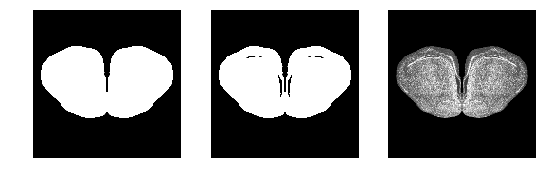

In [14]:
ref_im = pickle.load(open("ref_imgs_MT.pickle", "rb"))
mask_img = pickle.load(open("mask_img.pickle", "rb"))
mask_img_holes = pickle.load(open("mask_img_holes.pickle", "rb"))
reference_img = pickle.load(open("reference_img.pickle", "rb"))
ref_im["TOTAL"] = reference_img  #mask_img# 

plt.figure(figsize=(9,3))
ax = plt.subplot(131)
_= ax.imshow(mask_img, interpolation="none",cmap="gray")
plt.axis("off")
ax = plt.subplot(132)
_= ax.imshow(mask_img_holes, interpolation="none",cmap="gray")
plt.axis("off")
ax = plt.subplot(133)
_= ax.imshow(reference_img, interpolation="none",cmap="gray")
plt.axis("off")
#plt.savefig("../outputs/masj_reference.pdf",bbox_inches="tight")

In [15]:
D, projs_len = build_Design_Matrix(angles, widths, mask_img)
boundaries = np.r_[0,np.cumsum(projs_len)]
first_points = {'angle117':0,'angle45':4,'angle9':6,'angle153':8, 'angle81':6}

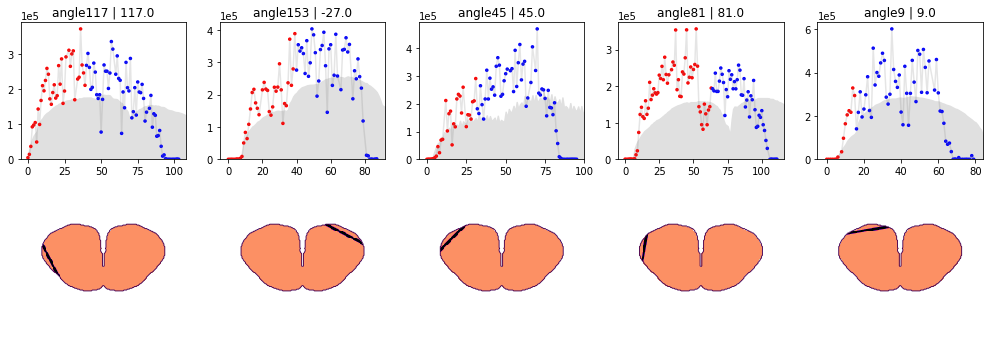

In [16]:
fig = plt.figure(figsize=(14,5.))
gs = plt.GridSpec(2,5)
import copy
palette = copy.copy(plt.cm.magma_r)
palette.set_under('w', alpha=0.0)

for i, (name_angle, df_angle) in enumerate(data_norm.items()):
    projected_total = D.dot(mask_img.flat[:])[boundaries[i]:boundaries[i+1]]
    ratio_factor = simps(df_angle.sum(0), get_x(df_angle)) / projected_total.sum()
    x = get_x(df_angle)
    y = data_norm[name_angle].sum(0)
    c = np.array(["k","r", "b"])[get_plate(data_norm[name_angle])]
    
    # Set the plot
    ax = plt.subplot(gs[0,i])
    # Plot points
    ax.scatter(x, y, c=c, marker=".", lw=0, s=50)
    ax.plot(x, y, alpha=0.2, c="gray")
    # Plot expected projection 
    #ax.plot(np.arange(projected_total.shape[0])+first_points[name_angle], projected_total*ratio_factor, c="k",lw=1.5,zorder=1000)
    ax.fill_between(np.arange(projected_total.shape[0])+first_points[name_angle], projected_total*ratio_factor, color="0.88",lw=1.5,zorder=-1)
    # Fix graphics
    ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    ax.set_title("%s | %s" % (name_angle, angles[i]/(np.pi/180.)-180))
    ax.set_xlim(-5,get_x(df_angle)[-1]+5)
    ax.set_ylim(-0.2,)
    
    #Set the plot
    ax = plt.subplot(gs[1,i])
    s, e = boundaries[i],boundaries[i+1]
    a,b = np.array([5,8]) + s
    ax.imshow( (0.5*D[s:e].sum(0)+D[a:b,:].sum(0)).reshape(mask_img.shape[0], mask_img.shape[1]), cmap=palette, vmin=0.2 )
    ax.contour(mask_img, [0.5], linewidths=[0.9])
    plt.axis("off")
    # Plot first 3 slides
plt.tight_layout();
#plt.savefig("../outputs/placeholder_total.pdf", bbox_inches="tight")

In [17]:
# Add a dummy gene "TOTAL" to mantain the same API
for angle in angles_dict.keys():
    data_norm[angle].loc["TOTAL",:] = data_norm[angle].loc[data_norm[angle].index != "TOTAL",:].sum(0) # written like this avoids problems if run twice
    manual_shift = {'angle9': -6, 'angle45': -5, 'angle81': -7, 'angle117': 0, 'angle153': -7}
prior_avgs = {k:np.rad2deg(v) for k,v in angles_dict.items()}
# prior_fp = {k:-v for k,v in manual_shift.items()}
# Found manually but very straightforward from the plots

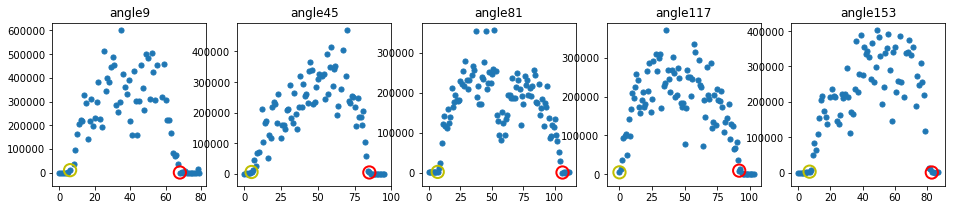

In [18]:
conv_hull = morphology.convex_hull_image(mask_img >= 0.2)  # Note: before 0.05
heuristic_wid = {}
extreme_angle_wid = {}
plt.figure(None, (16,3))
gs = plt.GridSpec(1, 5)
for i, angle_set in enumerate(["angle9", "angle45", "angle81", "angle117", "angle153"]):
    p = -manual_shift[angle_set]
    p_s, p_e = np.maximum(p - 3, 0), np.minimum(len(data_norm[angle_set].ix["TOTAL"].values)-1, p+2)
    thrs = np.mean( data_norm[angle_set].ix["TOTAL"].values[p_s:p_e])
    end_ix = np.where(np.diff((data_norm[angle_set].ix["TOTAL"].values > thrs).astype(int))==-1)[0][0]
    _x = get_x(data_norm[angle_set])
    end_ix = np.minimum(end_ix+1, len(_x)-1)
    n_slices = _x[end_ix] - _x[p] + 1
    angles_x = (np.pi - np.deg2rad(prior_avgs[angle_set] + np.arange(-10,10+1))) % (2 * np.pi)
    extensions = [tomography.core.all_slicing_parameters(conv_hull, angle_a)[4] for angle_a in angles_x]
    wmin = np.min(extensions)/n_slices
    wmax = np.max(extensions)/n_slices
    heuristic_wid[angle_set] = wmin, wmax
    extreme_angle_wid[angle_set] = extensions[0]/n_slices, extensions[-1]/n_slices
    plt.subplot(gs[i])
    plt.scatter(_x, data_norm[angle_set].ix["TOTAL"].values, s=26)
    plt.scatter(_x[end_ix], data_norm[angle_set].ix["TOTAL"].values[end_ix], s=150, edgecolor="r", facecolor="", lw=2)
    plt.scatter(_x[p], data_norm[angle_set].ix["TOTAL"].values[p], s=150,edgecolor="y", facecolor="", lw=2)
    plt.title(angle_set)

In [19]:
D_cache = DCache(1. * (mask_img_holes>0.2))  # in alternative use mask_img

In [20]:
optimal_corr_dict = {}
optimal_L2_dict = {}
optimal_df = pd.DataFrame(columns=["angle", "widths", "shifts"],dtype=object)

# DATA
for angle_set in ['angle117', 'angle45', 'angle9', 'angle153', 'angle81']:
    optimal_corr_dict[angle_set] = pd.DataFrame(columns=["angle", "widths", "shifts"], dtype=object)
    optimal_L2_dict[angle_set] = pd.DataFrame(columns=["angle", "widths", "shifts"],dtype = object)

    for gene in ["TOTAL"]:  # ref_im.keys():
        print(angle_set, gene)
        x_raw = get_x(data_norm[angle_set])
        y_raw = data_norm[angle_set].ix[gene].values
        x, y = interpolate(x_raw, y_raw)

        # PREDICTED
        angles_probes = np.arange(prior_avgs[angle_set]-10, prior_avgs[angle_set]+10)
        wid_probes = np.round(np.arange(heuristic_wid[angle_set][0], heuristic_wid[angle_set][1]+0.02, 0.02), 3)
        
        fp = manual_shift[angle_set]
        record = grid_score_prediction(angles_probes, wid_probes, D_cache, ref_im[gene].flat[:], y, (fp, fp), return_ys=False)

        prior = 1 # gauss_kernel(angles_probes, prior_avgs[angle_set], 50)[:,None]
        # Optimum correltion
        arminsCor = np.argmin(record["corr_score"]/prior, 0)
        arminCor = np.argmin(record["corr_score"][arminsCor, np.arange(record["corr_score"].shape[1])])
        optimal_corr_dict[angle_set].loc[gene,:] = angles_probes[arminsCor[arminCor]], wid_probes[arminCor], record["x_shift"][arminsCor[arminCor], arminCor]
        # Optimum rss
        arminsL2 = np.argmin(record["L2_score"]/prior, 0)
        arminL2 = np.argmin(record["L2_score"][arminsL2, np.arange(record["L2_score"].shape[1])])
        optimal_L2_dict[angle_set].loc[gene,:] = angles_probes[arminsL2[arminL2]], wid_probes[arminL2], record["x_shift"][arminsL2[arminL2], arminL2]
        
        if gene == "TOTAL":
            optimal_df.loc[f"{angle_set}_corr",:] = angles_probes[arminsCor[arminCor]], wid_probes[arminCor], record["x_shift"][arminsCor[arminCor], arminCor]
            optimal_df.loc[f"{angle_set}_L2",:] = angles_probes[arminsL2[arminL2]], wid_probes[arminL2], record["x_shift"][arminsL2[arminL2], arminL2]

angle117 TOTAL
angle45 TOTAL
angle9 TOTAL
angle153 TOTAL
angle81 TOTAL


In [21]:
angles_optimum = np.deg2rad(np.array([optimal_df.loc[f"{angle_set}_corr"].values[0] for angle_set in data_norm.keys()]))
widths_optimum = np.array([optimal_df.loc[f"{angle_set}_corr"].values[1] for angle_set in data_norm.keys()])
first_points_optimum = [-optimal_df.loc[f"{angle_set}_corr"].values[2] for angle_set in data_norm.keys()]
first_points_opt_dict = {angle_set:-optimal_df.loc[f"{angle_set}_corr"].values[2] for angle_set in data_norm.keys()}

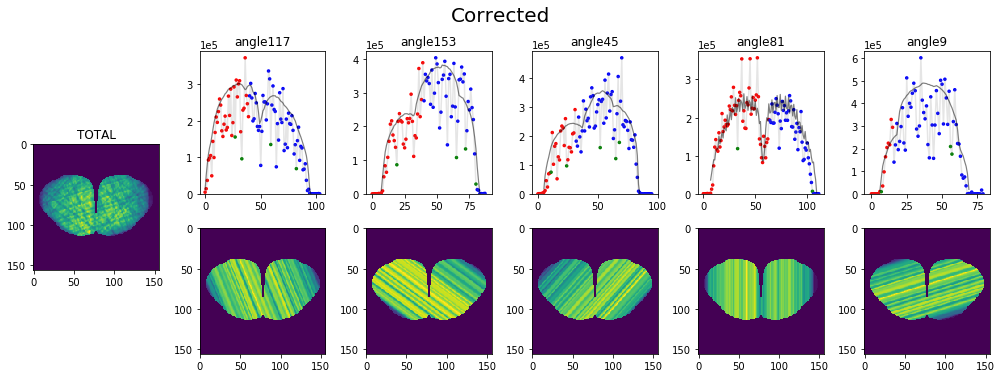

In [22]:
fig = plt.figure(figsize=(14,5.))
plt.suptitle("Corrected", y=1.05, fontsize=20)
tomography.plot_projection_check("TOTAL", data_norm, angles_optimum, widths_optimum, first_points_opt_dict, mask_img)

In [23]:
# creating configuration file
angles_names = list(data_norm.keys())
rec_conf = tomography.ReconstructionConfig(angles_names=angles_names,
                                     mask=mask_img_holes,
                                     mask_thrs=0.2,
                                     reference_mask=reference_img*mask_img_holes,
                                     symmetry=True,
                                     masked_formulation=True,
                                     angles_values=angles_optimum,
                                     first_points=first_points_optimum,
                                     widths=widths_optimum)

# creating dictionary of gene values
all_gene_values_dict = {gene:{name_angle:data_norm[name_angle].ix[gene].values for name_angle in data_norm.keys()} for gene in data_norm["angle81"].index}

In [24]:
# writing files to hdf5

# gene values file
f = h5py.File('Lizard_gene_values.hdf5', "w")
for i, (k, d) in enumerate(all_gene_values_dict.items()):
    for k2, v in d.items():
        f.create_dataset("/genes/%s/%s" % (k,k2), data=v)
for name_angle in data_norm.keys():
    f.create_dataset("coordinates/%s" % name_angle, data=get_x(data_norm[name_angle]) )
f.close()

#config file
rec_conf.to_file("Lizard_config.hdf5")

OSError: File exist, cannot overwrite

In [25]:
tg = tomography.Tomographer()
tg.load_cfg(rec_conf)
tg.connect_data('Lizard_gene_values.hdf5')


result = tg.reconstruct('TAC1', alpha_beta='auto', crossval_kwargs={'domain': [(0,4), (0.05,6)],
                                                                                       'logged_grid':False,
                                                                                       'extra_evals': 5,
                                                                                       'initial_grid_n': 4},nb_r=1.2) # crossval_kwargs={"domain":[(-5, 0.8), (-6, 2.5)]} # alpha_beta=(1,0.01)
    

 It might results in errors 
Filling with sorted(list(self.f["genes"].keys()))


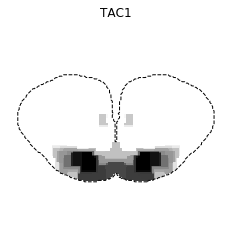

In [26]:
tomography.show_reconstruction_raw(result, mask_img)
plt.title('TAC1')
plt.show()

In [34]:
# Read config files
config = h5py.File("Lizard_config.hdf5", mode="r")
alpha_betas = h5py.File('ALPHA_BETA_OUTPUT.hdf5', mode='r')
input_genes = h5py.File("Lizard_gene_values.hdf5", mode="r")
gene_file = h5py.File("OUTPUT.hdf5", mode="r")
reference_mask = config['reference_mask'][:]
mask = config['mask_g'][:]


reference_mask = config["reference_mask"][:]
config.close()

connectivity = tomography.create_connectivity(mask)

# List genes
genes = list(gene_file.keys())
N_genes= len(genes)

MemoryError: Unable to allocate 4.64 GiB for an array with shape (24964, 24964) and data type float64